**Step 1: Import libraries and load cleaned data**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set(style='whitegrid')

# Load datasets again
fear_greed_path = '/content/fear_greed_index.csv'
historical_data_path = '/content/historical_data.csv'

fear_greed_df = pd.read_csv(fear_greed_path)
historical_df = pd.read_csv(historical_data_path)

# Preprocessing (same as before)
fear_greed_df['date'] = pd.to_datetime(fear_greed_df['date'], errors='coerce')
historical_df['Timestamp IST'] = pd.to_datetime(historical_df['Timestamp IST'], format='%d-%m-%Y %H:%M', errors='coerce')
numeric_cols = ['Execution Price', 'Size Tokens', 'Size USD', 'Closed PnL', 'Fee']
for col in numeric_cols:
    historical_df[col] = pd.to_numeric(historical_df[col], errors='coerce')
historical_df['date'] = historical_df['Timestamp IST'].dt.date
historical_df['date'] = pd.to_datetime(historical_df['date'])

# Create outputs folder if not exists
output_dir = 'outputs'
import os
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

**Step 2: Merge datasets on date**

In [3]:
# Merge historical trader data with fear & greed index on date
merged_df = pd.merge(historical_df, fear_greed_df, on='date', how='left')

print("Merged Data Info:")
print(merged_df.info())
print(merged_df.head())

Merged Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Account           211224 non-null  object        
 1   Coin              211224 non-null  object        
 2   Execution Price   211224 non-null  float64       
 3   Size Tokens       211224 non-null  float64       
 4   Size USD          211224 non-null  float64       
 5   Side              211224 non-null  object        
 6   Timestamp IST     211224 non-null  datetime64[ns]
 7   Start Position    211224 non-null  float64       
 8   Direction         211224 non-null  object        
 9   Closed PnL        211224 non-null  float64       
 10  Transaction Hash  211224 non-null  object        
 11  Order ID          211224 non-null  int64         
 12  Crossed           211224 non-null  bool          
 13  Fee               211224 non-null  float6

**Step 3: Analyze relationship between sentiment and trading metrics**

3.1 Average daily PnL by sentiment classification

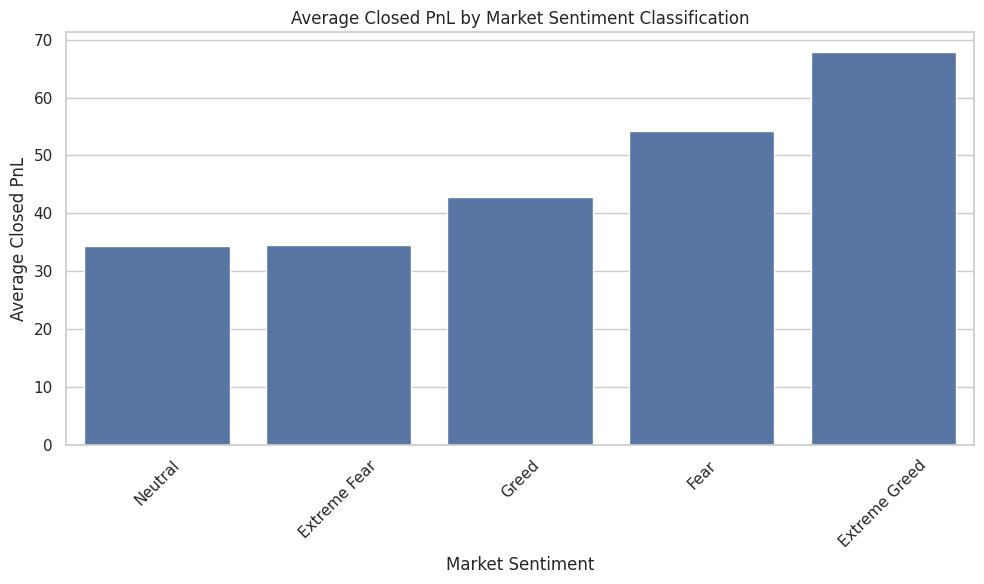

In [4]:
avg_pnl_by_sentiment = merged_df.groupby('classification')['Closed PnL'].mean().reset_index()

plt.figure(figsize=(10,6))
sns.barplot(data=avg_pnl_by_sentiment, x='classification', y='Closed PnL', order=avg_pnl_by_sentiment.sort_values('Closed PnL')['classification'])
plt.title('Average Closed PnL by Market Sentiment Classification')
plt.xlabel('Market Sentiment')
plt.ylabel('Average Closed PnL')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f'{output_dir}/avg_pnl_by_sentiment.png')
plt.show()

**3.2 Average daily trading volume by sentiment classification**

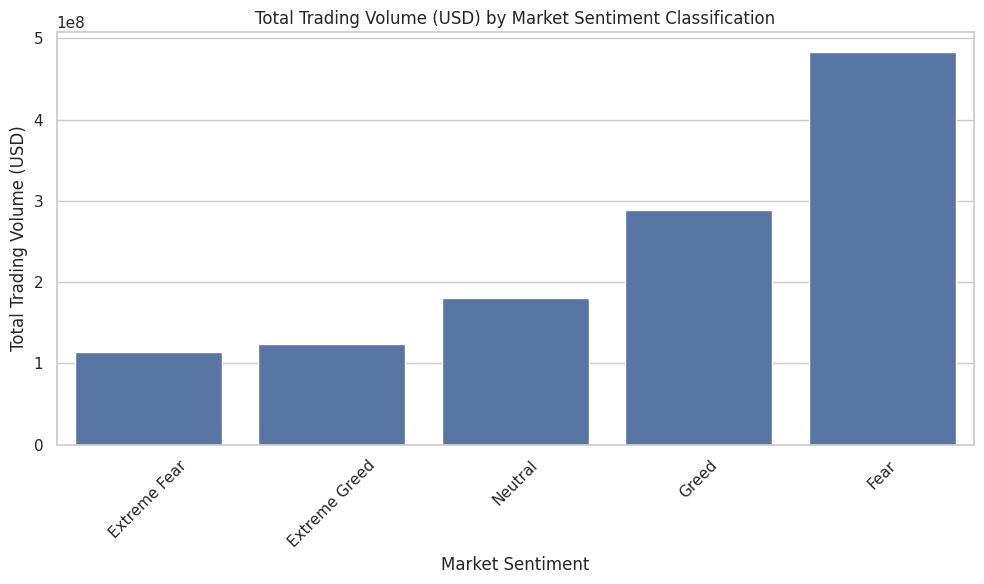

In [5]:
avg_volume_by_sentiment = merged_df.groupby('classification')['Size USD'].sum().reset_index()

plt.figure(figsize=(10,6))
sns.barplot(data=avg_volume_by_sentiment, x='classification', y='Size USD', order=avg_volume_by_sentiment.sort_values('Size USD')['classification'])
plt.title('Total Trading Volume (USD) by Market Sentiment Classification')
plt.xlabel('Market Sentiment')
plt.ylabel('Total Trading Volume (USD)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f'{output_dir}/volume_by_sentiment.png')
plt.show()

**3.3 Distribution of leverage by sentiment (if leverage column exists)**

In [6]:
if 'Leverage' in merged_df.columns:
    plt.figure(figsize=(10,6))
    sns.boxplot(data=merged_df, x='classification', y='Leverage')
    plt.title('Leverage Distribution by Market Sentiment Classification')
    plt.xlabel('Market Sentiment')
    plt.ylabel('Leverage')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'{output_dir}/leverage_by_sentiment.png')
    plt.show()
else:
    print("Leverage column not found in dataset.")

Leverage column not found in dataset.


**Step 4: Time-lagged analysis (optional but insightful)**

Check if sentiment on day X affects trading behavior on day X+1.

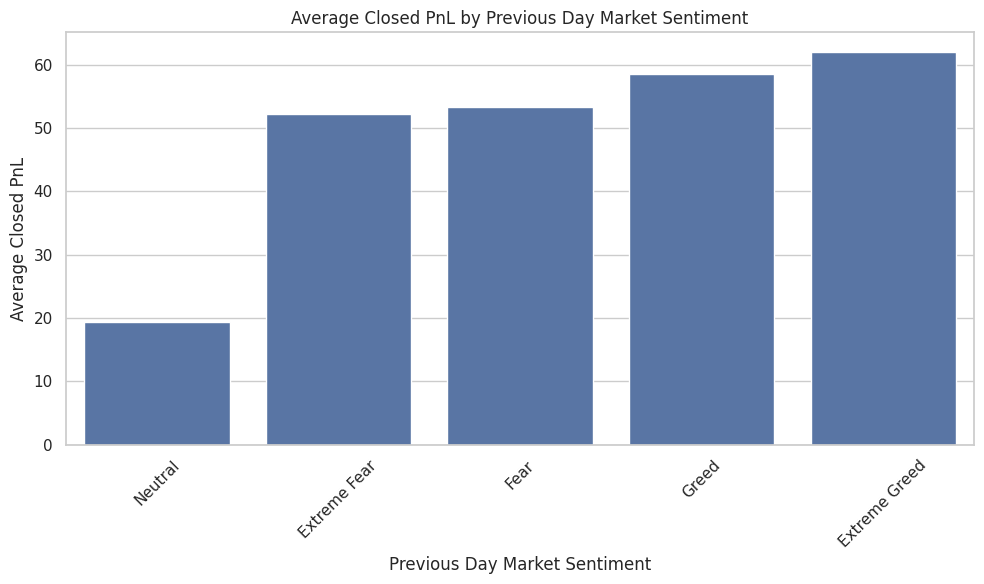

In [7]:
# Shift sentiment by 1 day to create lagged sentiment
fear_greed_df['date'] = pd.to_datetime(fear_greed_df['date'])
fear_greed_df['classification_lag1'] = fear_greed_df['classification'].shift(1)

# Merge lagged sentiment with historical data
merged_lagged_df = pd.merge(historical_df, fear_greed_df[['date', 'classification_lag1']], on='date', how='left')

# Average PnL by lagged sentiment
avg_pnl_lagged = merged_lagged_df.groupby('classification_lag1')['Closed PnL'].mean().reset_index()

plt.figure(figsize=(10,6))
sns.barplot(data=avg_pnl_lagged, x='classification_lag1', y='Closed PnL', order=avg_pnl_lagged.sort_values('Closed PnL')['classification_lag1'])
plt.title('Average Closed PnL by Previous Day Market Sentiment')
plt.xlabel('Previous Day Market Sentiment')
plt.ylabel('Average Closed PnL')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f'{output_dir}/avg_pnl_by_lagged_sentiment.png')
plt.show()

**Step 5: Statistical Testing (Optional)**

Example: ANOVA to check if PnL differs significantly across sentiment classes.

In [8]:
from scipy.stats import f_oneway

groups = [group['Closed PnL'].dropna() for name, group in merged_df.groupby('classification')]

anova_result = f_oneway(*groups)
print("ANOVA test result for Closed PnL across sentiment classes:")
print(f"F-statistic: {anova_result.statistic:.4f}, p-value: {anova_result.pvalue:.4f}")

ANOVA test result for Closed PnL across sentiment classes:
F-statistic: 9.0622, p-value: 0.0000


In [9]:
!zip -r outputs.zip outputs

  adding: outputs/ (stored 0%)
  adding: outputs/volume_by_sentiment.png (deflated 18%)
  adding: outputs/avg_pnl_by_lagged_sentiment.png (deflated 18%)
  adding: outputs/avg_pnl_by_sentiment.png (deflated 18%)
